In [48]:
import pandas as pd
pd.options.plotting.backend = "plotly"
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px


### Load the sampled version of the dataset (5 000 songs)

In [8]:
df = pd.read_csv("./data/song_lyrics_sampled.csv")
print('Data rows number: ', len(df))
df.head()

Data rows number:  5000


,title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language
0,Etap,rap,Der Plot,2014,124,{},"[Part I - Conny:]\nGuten Morgen fremdes Bett, ...",383522,de,de,de
1,Toothpick,pop,Biting Elbows,2012,8873,{},Some folks got the patience of the angels\nNot...,1166787,en,en,en
2,6 Feet Under,pop,Ana Johnsson,2004,60,{},You just left me 6 feet under ground I'm burni...,803057,en,en,en
3,Ir Al Baile,pop,Onda Vaga,2015,731,{},Cuando a los doce llevé la bandera en el hombr...,905848,es,es,es
4,Prudenza mai,pop,Ivan Graziani,1989,35,{},"Prudenza mai, mai...\nMai neanche da bambino\n...",1304379,it,it,it


### Drop useless columns and keep only english songs

In [9]:
# consider only english songs
df = df[df.language == 'en']
# drop rows containing NaN values
df = df.dropna()
# drop useless columns
df = df.drop(['language_cld3', 'language_ft','language','features','views'], axis=1)
print('Data rows number: ', len(df))
df.head()

Data rows number:  3919


,title,tag,artist,year,lyrics,id
1,Toothpick,pop,Biting Elbows,2012,Some folks got the patience of the angels\nNot...,1166787
2,6 Feet Under,pop,Ana Johnsson,2004,You just left me 6 feet under ground I'm burni...,803057
5,The Poetaster Act 4. Scene 2,misc,Ben Jonson,1601,"A Room in Lupus's House.\n\nEnter Lupus, HISTR...",674438
6,Hes Gone,pop,Phil Lesh & Friends,2015,"Rat in a drain ditch, caught on a limb, you kn...",961823
7,Ill Never Say,pop,Helen Ward,2015,"I'll never say ""never again"" again\nCause here...",1163619


### Dataset preprocessing

In [10]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('punkt',quiet=True)
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)

stop_words = stopwords.words('english')
new_stop_words = ['ooh','yeah','hey','whoa','woah', 'ohh', 'was', 'mmm', 'oooh','yah','yeh','mmm', 'hmm','deh','doh','jah']
stop_words.extend(new_stop_words)


def preprocess_text(text):
    # remove \n and words containing '
    text = text.replace('\n', ' ')
    text = re.sub(r'\b\w*\'\w*\b', '', text)
    # remove punctuation
    text = re.sub(r'[,\.!?]', '', text)
    #removing text in square braquet
    text = re.sub(r'\[.*?\]', ' ', text)
    #removing numbers
    text = re.sub(r'\w*\d\w*',' ', text)
    #removing bracket
    text = re.sub(r'[()]', ' ', text)
    #removing underscore at the beginning or at the end of the word
    text = re.sub(r'^_|_$', '', text)
    #removing multiple spaces (merge > 2 spaces in one space)
    text = re.sub(r' {2,}', ' ', text)
    # convert all words in lower case
    text = text.lower()
    # tokenize
    tokens = word_tokenize(text)
    # remove stop words
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # lemmatize
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    #remove tokens with lenght < 3
    final_tokens = [token for token in lemmatized_tokens if len(token) > 2]

    return ' '.join(final_tokens)

cleaned_text = df["lyrics"].apply(preprocess_text)
df["lyrics_proc"] = cleaned_text
df.head()

,title,tag,artist,year,lyrics,id,lyrics_proc
1,Toothpick,pop,Biting Elbows,2012,Some folks got the patience of the angels\nNot...,1166787,folk got patience angel heart well yearns veng...
2,6 Feet Under,pop,Ana Johnsson,2004,You just left me 6 feet under ground I'm burni...,803057,left foot ground burning sight light foot buri...
5,The Poetaster Act 4. Scene 2,misc,Ben Jonson,1601,"A Room in Lupus's House.\n\nEnter Lupus, HISTR...",674438,room house enter lupus histrio lictors tuc sta...
6,Hes Gone,pop,Phil Lesh & Friends,2015,"Rat in a drain ditch, caught on a limb, you kn...",961823,rat drain ditch caught limb know better know l...
7,Ill Never Say,pop,Helen Ward,2015,"I'll never say ""never again"" again\nCause here...",1163619,never say never cause love head heel love neve...


In [11]:
df.to_csv("./data/song_lyrics_sampled_proc.csv", header='true', index=False)

### Analysis

#### Top-10 most common words in the entire corpus

In [12]:
from collections import Counter
all_words = ' '.join(df['lyrics_proc']).split()

# Count the frequency of each word
word_counts = Counter(all_words)

# Get the 10 most common words
most_common_10 = word_counts.most_common(10)

# Display the results
print("The 10 most frequent words are:")
for word, count in most_common_10:
    print(f"{word}: {count}")

The 10 most frequent words are:
like: 7755
know: 6447
got: 5504
get: 5070
one: 4752
love: 4537
time: 4408
see: 3907
never: 3472
make: 3345


#### Genre

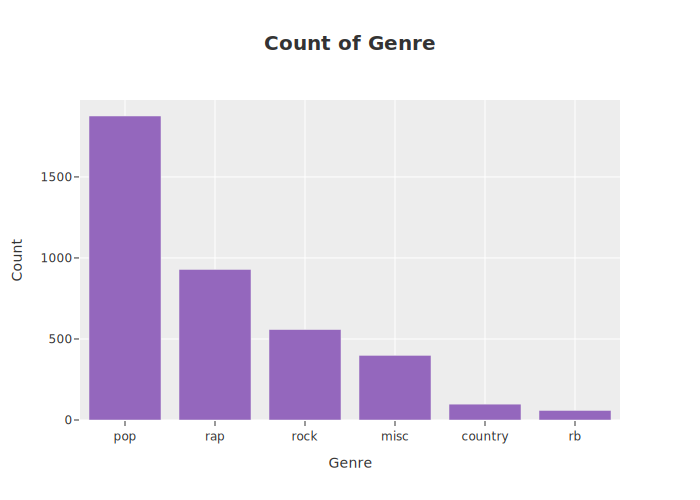

In [28]:
# Calculate the value counts
genre_counts = df['tag'].value_counts()

# Create the bar chart
fig_genre = go.Figure(data=[
    go.Bar(
        x=genre_counts.index,
        y=genre_counts.values,
        marker_color='rgb(148, 103, 189)'  # Change the color
    )
])

# Update layout
fig_genre.update_layout(
    title=dict(
        text='<b>Count of Genre</b><br>',
        font=dict(size=20)
    ),
    width=700,
    height=500,
    xaxis=dict(title='Genre'),
    yaxis=dict(title='Count'),
    template='ggplot2'  # Applying the ggplot2 template
)

# Show plot
fig_genre.show('svg')

# Save plot
pio.write_image(fig_genre, './plots/count_genre.pdf')

#### Lyrics length

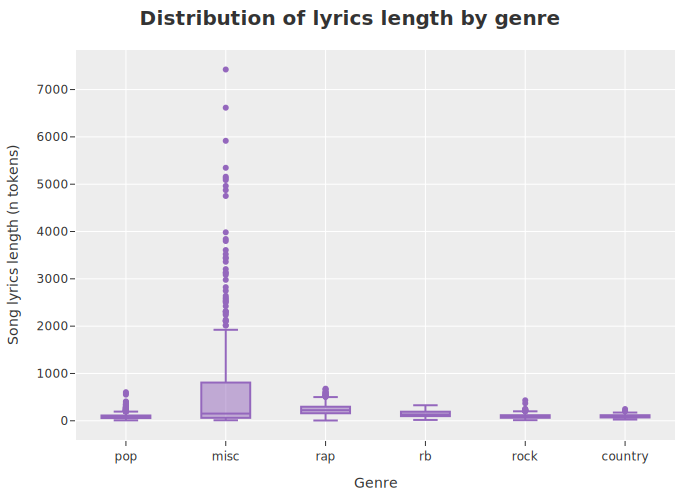

In [34]:
# Get lyric frequencies for each song
df['lyrics_num_tks'] = df['lyrics_proc'].map(lambda x: len(x.split()))

# Create a dictionary to store lyrics length by genre
lyric_count_dict = {genre: df[df['tag'] == genre]['lyrics_num_tks'].tolist() for genre in df['tag'].unique()}

# Create box plot traces for each genre
traces = []
for genre, counts in lyric_count_dict.items():
    traces.append(go.Box(
        y=counts,
        name=genre,
        marker_color='rgb(148, 103, 189)'  # Change the color
    ))

# Create the figure
fig_dist = go.Figure(data=traces)

# Update layout
fig_dist.update_layout(
    title=dict(
        text='<b>Distribution of lyrics length by genre</b><br>',
        font=dict(size=20)
    ),
    margin=dict(l=25, r=25, b=50, t=50, pad=0),
    width=700,
    height=500,
    xaxis=dict(
        title_text='Genre'
    ),
    yaxis=dict(
        title_text='Song lyrics length (n tokens)'
    ),
    template='ggplot2',  # Applying the ggplot2 template
    showlegend=False  # Remove the legend
)

# Show plot
fig_dist.show('svg')

# Save plot
pio.write_image(fig_dist, './plots/lyrics_length.pdf')

#### POS tagging

In [35]:
import spacy

#load spacy model
nlp = spacy.load('en_core_web_sm')

def pos(tks,pos):
    
    """Returns any token that qualifies as a specific part of speech"""
    doc = nlp(tks) #fit model
    
    return ' '.join(list(set([i.text for i in doc if i.pos_ == pos]))) #return any tokens that qualify

#get nouns
df['nouns'] = df.lyrics_proc.map(lambda x: pos(x,'NOUN'))

#get verbs
df['verbs'] = df.lyrics_proc.map(lambda x: pos(x,'VERB'))

#get adjectives
df['adjectives'] = df.lyrics_proc.map(lambda x: pos(x,'ADJ'))

#get adverbs
df['adverbs'] = df.lyrics_proc.map(lambda x: pos(x,'ADV'))

In [36]:
df.iloc[:5,-4:]

,nouns,verbs,adjectives,adverbs
1,brake light law petrol mile heart grin yearns ...,stayed crossed got look drove spoken know eat ...,great bad moral lower strong low crossed flawe...,halfway maybe still better well away softly back
2,foot tearing sight life light word time burnin...,tearing gone spoken left let drown burning com...,wrong scar open long,still apart far stroke around
5,player theatre wot jupiter purchase love proje...,throw made let hire look worship give tell dea...,much physic pothecary cunning able sure good a...,forward half yet here
6,chain mile head ditch limb skid price pistol d...,gone lost know told drain left bring blow caug...,round old hot locomotive high cold right cool ...,maybe back better
7,love sky thing thought heel head,cause kissing kiss die missed walked said say,sweet,never away


#### Common words

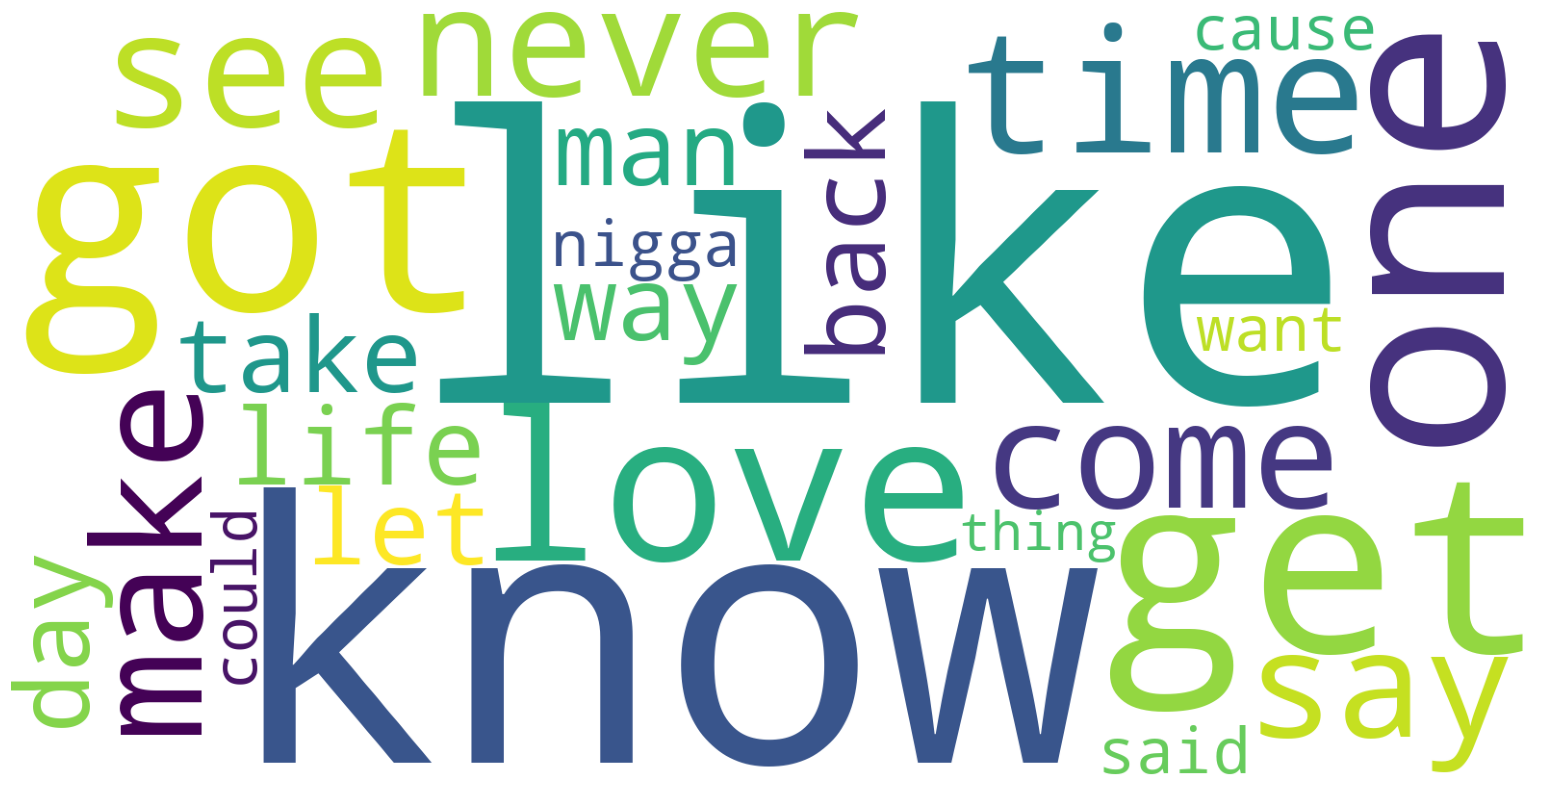

In [41]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt   

def mostcommonTokens(data,token=1):
    
    """Returns a DataFrame of the most common n (arg)tokens in a string. Excludes stop words. Additional
    stop words can be added"""

    #instantiate count vectorizer and specify tokens
    vect = CountVectorizer(stop_words=new_stop_words, ngram_range= (token,token))

    #fit vectorizer
    X = vect.fit_transform(data)
    
    #get word counts as DataFrame
    word_counts = pd.DataFrame(np.asarray(X.sum(axis=0))[0],vect.get_feature_names_out(),columns=['count'])
    
    #sort by count
    word_counts = word_counts.sort_values(by='count', ascending=False)

    return word_counts #return DataFrame
N = 25
top_tks = mostcommonTokens(df.lyrics_proc,token=1).head(N)
wordcloud = WordCloud(background_color='white', width = 1600, height = 800,collocations=False,random_state=100,stopwords=stopwords.words('english')).generate_from_frequencies(top_tks['count'].to_dict())
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('./plots/word_cloud.pdf')

#### Common words tagged as name by genre

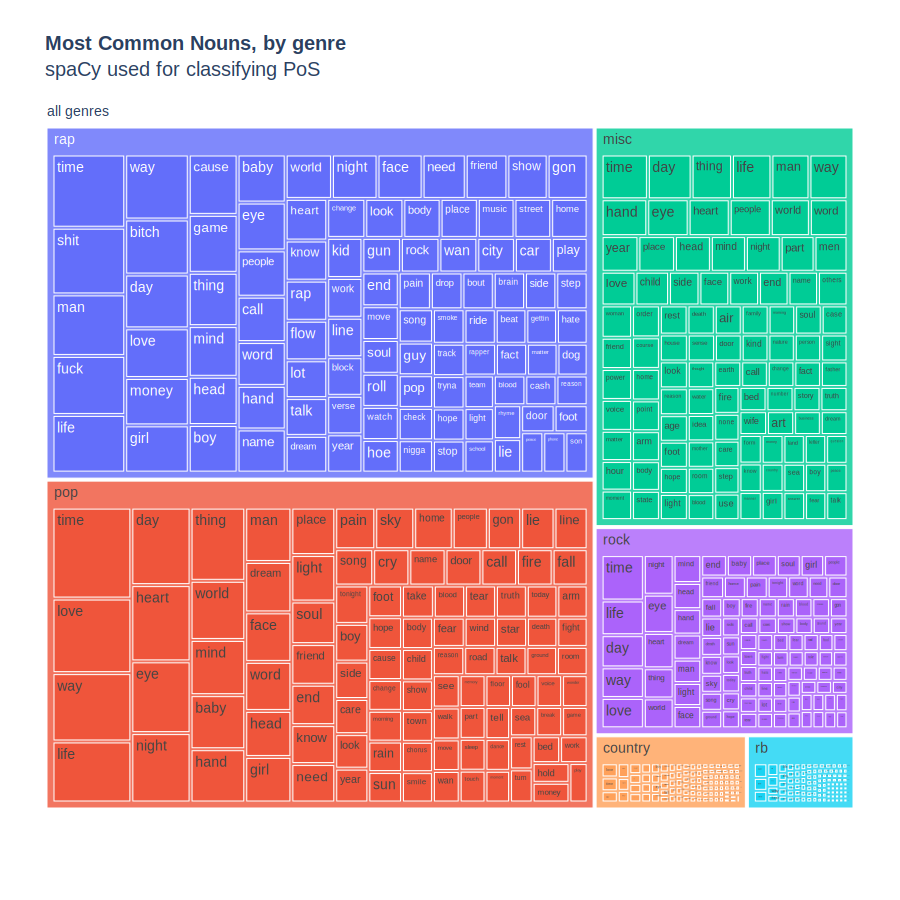

In [49]:
def genius_genremap(df,pos,n=100):
    
    """Visualisation function. Returns a treemap of the most common n tokens that qualify as a part of speech
    Requires the mostcommonTokens function"""
    
    #list to populate subset DataFrame's
    all_df = []

    #loop through unique genres
    for i in df.tag.unique():

        #get most common tokens for part of speech
        temp_df = mostcommonTokens(df[df['tag'] == i][pos]).head(n)
        
        #add column for current genre
        temp_df['tag'] = i

        #append DataFrame to list
        all_df.append(temp_df)

    #concatenate all DataFrame's
    all_df = pd.concat([i for i in all_df])

    #reset index
    all_df.reset_index(drop=False,inplace=True)

    #column labels
    all_df.columns = ['word','count','tag']

    # in order to have a single root node add 'all genres'
    all_df["all genres"] = "all genres" 

    #create plotly treemap figure
    fig = px.treemap(all_df, path=['all genres', 'tag', 'word'], values='count',)
    
    #title parameters
    title_param = dict(text='<b>Most Common Nouns, by genre</b><br>spaCy used for classifying PoS</b>', 
                        font=dict(size=20))
    
    #update layout
    fig.update_layout(title=title_param,
                    font= dict(family='Helvetica',size=14),
                    width=900,
                    height=900,
                    autosize=False,
                    margin=dict(l=40,r=40,b=85,t=100,pad=0,))
        
    #show plot
    fig.show('svg')
    
    # Save plot
    pio.write_image(fig, './plots/genre_map.pdf')
    return fig

noun_treemap = genius_genremap(df,pos='nouns')